In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import re
import ast
import pandas as pd


In [6]:
# beam_jsonl_path = "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/beam_numina/Numina_beam_search_2_4_40/beam_search_completions.jsonl"
beam_jsonl_path = "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32_numina/best_of_4_bootstrap_out.jsonl"

beam_data = []
with open(beam_jsonl_path, "r") as f:
    for i, line in enumerate(f):
        if i >= 5:  # Only read first 5 lines for inspection
            break
        beam_data.append(json.loads(line))

# Display the first few records
for idx, record in enumerate(beam_data):
    print(f"Record {idx}:")
    for k, v in record.items():
        print(f"  {k}: {v if len(str(v)) < 200 else str(v)[:200] + '...'}")
    print("-" * 40)


Record 0:
  source: synthetic_math
  problem: Consider the terms of an arithmetic sequence: $-\frac{1}{3}, y+2, 4y, \ldots$. Solve for $y$.
  solution: For an arithmetic sequence, the difference between consecutive terms must be equal. Therefore, we can set up the following equations based on the sequence given:
\[ (y + 2) - \left(-\frac{1}{3}\right)...
  messages: [{'content': 'Consider the terms of an arithmetic sequence: $-\\frac{1}{3}, y+2, 4y, \\ldots$. Solve for $y$.', 'role': 'user'}, {'content': 'For an arithmetic sequence, the difference between consecu...
  answer: \frac{13}{6}
  completions: ["To solve for $y$ in the arithmetic sequence $-\\frac{1}{3}, y+2, 4y, \\ldots$, we will use the properties of an arithmetic sequence. An arithmetic sequence is defined such that the difference betwee...
  scores: [[0.99609375, 0.99609375, 0.0048217773, 0.90625, 0.98828125, 0.91015625, 0.99609375, 1.0, 0.9921875], [0.953125, 0.001953125, 0.1572265625, 0.123046875, 0.36328125, 0.009277343

#### Loading Soft Labels

In [ ]:
import pandas as pd
import json

# Paths to the JSONL files
input_files = {
    "softlabels_2": "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/softlabels_2.jsonl",
    "softlabels_4": "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/softlabels_4.jsonl",
    "softlabels_8": "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/softlabels_8.jsonl",
    "softlabels_16": "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/softlabels_16.jsonl",
    "softlabels_32": "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/parallel_best_of_32/softlabels_32.jsonl",
}

# Load each JSONL file into a DataFrame
dataframes = {}
for label, path in input_files.items():
    data = []
    with open(path, "r") as infile:
        for line in infile:
            data.append(json.loads(line))
    df = pd.DataFrame(data)
    dataframes[label] = df

# Merge the DataFrames on the "problem" column
merged_df = dataframes["softlabels_2"]
for label in ["softlabels_4", "softlabels_8", "softlabels_16", "softlabels_32"]:
    merged_df = merged_df.merge(dataframes[label], on="problem", suffixes=("", f"_{label}"))

merged_df.head()


,problem,sl_weighted_2,sl_naive_2,sl_maj_2,sl_weighted_2_softlabels_4,sl_naive_2_softlabels_4,sl_maj_2_softlabels_4,sl_weighted_2_softlabels_8,sl_naive_2_softlabels_8,sl_maj_2_softlabels_8,sl_weighted_2_softlabels_16,sl_naive_2_softlabels_16,sl_maj_2_softlabels_16,sl_weighted_2_softlabels_32,sl_naive_2_softlabels_32,sl_maj_2_softlabels_32
0,"Convert the point $(0,3)$ in rectangular coord...",0.64,0.64,0.44,0.58,0.74,0.54,0.66,0.76,0.68,0.74,0.78,0.66,1.00,0.94,1.00
1,Define\n\[p = \sum_{k = 1}^\infty \frac{1}{k^2...,0.30,0.30,0.16,0.34,0.42,0.24,0.50,0.66,0.30,0.66,0.72,0.50,0.04,0.00,0.08
2,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...",0.92,0.92,0.74,0.98,0.96,0.98,0.98,0.90,0.98,1.00,0.92,1.00,1.00,0.98,1.00
3,How many positive whole-number divisors does 1...,0.92,0.92,0.92,1.00,0.98,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
4,The results of a cross-country team's training...,0.64,0.64,0.36,0.66,0.66,0.62,0.78,0.58,0.74,0.92,0.54,0.90,0.98,0.50,0.96


In [3]:
# read in this file.
import sys
import os
sys.path.append('/dccstor/gma2/jhjenny9/search-and-learn/scripts/data_processing')

# Now you can import the module
import extract_sl_maj_N

softlabels_2_path = "/dccstor/gma2/jhjenny9/search-and-learn/data/sl/sequential/softlabels_2.jsonl"

softlabels_2 = extract_sl_maj_N.extract_sl_maj_N_from_jsonl(softlabels_2_path, 2)
softlabels_2.head()

AttributeError: module 'extract_sl_maj_N' has no attribute 'extract_sl_maj_N_from_jsonl'

In [ ]:
# read in this file.
# import sys
# import os
# sys.path.append('/dccstor/gma2/jhjenny9/search-and-learn/scripts/data_processing')

# Now you can import the module
# import extract_sl_maj_N

# softlabels_2_path = "/dccstor/gma2/jhjenny9/search-and-learn/data/sl/parallel/softlabels_2.jsonl"
# beam_2_completions_path = "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/Numina_beam_search_4_4_40_second_chunk/beam_search_completions.jsonl"
# beam_2_softlabels_path = "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/Math500_beam_search_2_4_40/softlabels_2.jsonl"
beam_8_completions = '/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/Numina_beam_search_2_4_40_second_chunk/beam_search_completions.jsonl'
beam_type_2_completions = '/dccstor/gma2/jhjenny9/search-and-learn/data/Numina_Beam/beam_search_8_4_40_chunk_22000_23000/beam_search_completions.jsonl'

# Read and print the keys present in the first few lines of the file
with open(beam_type_2_completions, "r") as f:
    for i in range(5):
        line = f.readline()
        if not line:
            break
        data = json.loads(line)
        print(list(data.keys()))

# type 1 files: ['source', 'problem', 'solution', 'messages', 'answer', 'completions', 'pred', 'completion_tokens', 'scores', 'agg_scores', 'pred_weighted@1', 'pred_maj@1', 'pred_naive@1', 'indicator_weighted@1', 'indicator_maj@1', 'indicator_naive@1', 'correctness@1', 'pred_weighted@2', 'pred_maj@2', 'pred_naive@2', 'indicator_weighted@2', 'indicator_maj@2', 'indicator_naive@2', 'correctness@2']
# type 2 files: ['source', 'problem', 'solution', 'messages', 'answer', 'completions', 'pred', 'completion_tokens', 'scores', 'agg_scores', 'pred_weighted@1', 'pred_maj@1', 'pred_naive@1', 'indicator_weighted@1', 'indicator_maj@1', 'indicator_naive@1', 'correctness@1', 'pred_weighted@2', 'pred_maj@2', 'pred_naive@2', 'indicator_weighted@2', 'indicator_maj@2', 'indicator_naive@2', 'correctness@2']
# two file type are the same, except one has more questions.

['source', 'problem', 'solution', 'messages', 'answer', 'completions', 'pred', 'completion_tokens', 'scores', 'agg_scores', 'pred_weighted@1', 'pred_maj@1', 'pred_naive@1', 'indicator_weighted@1', 'indicator_maj@1', 'indicator_naive@1', 'correctness@1', 'pred_weighted@2', 'pred_maj@2', 'pred_naive@2', 'indicator_weighted@2', 'indicator_maj@2', 'indicator_naive@2', 'correctness@2', 'pred_weighted@4', 'pred_maj@4', 'pred_naive@4', 'indicator_weighted@4', 'indicator_maj@4', 'indicator_naive@4', 'correctness@4', 'pred_weighted@8', 'pred_maj@8', 'pred_naive@8', 'indicator_weighted@8', 'indicator_maj@8', 'indicator_naive@8', 'correctness@8']
['source', 'problem', 'solution', 'messages', 'answer', 'completions', 'pred', 'completion_tokens', 'scores', 'agg_scores', 'pred_weighted@1', 'pred_maj@1', 'pred_naive@1', 'indicator_weighted@1', 'indicator_maj@1', 'indicator_naive@1', 'correctness@1', 'pred_weighted@2', 'pred_maj@2', 'pred_naive@2', 'indicator_weighted@2', 'indicator_maj@2', 'indicator

In [15]:
import pandas as pd

beam_softlabels_path = "/dccstor/gma2/jhjenny9/search-and-learn/data/sl/beam/softlabels_beam_df.csv"
parallel_softlabels_path = "/dccstor/gma2/jhjenny9/search-and-learn/data/sl/parallel/softlabels_parallel_df.csv"

# Read the CSV file
parallel_softlabels_df = pd.read_csv(parallel_softlabels_path)

# # Show the first few lines
# print(beam_softlabels_df.head())
print(parallel_softlabels_df.head())

# # Show the shape of the DataFrame
# print(beam_softlabels_df.shape)
# print(parallel_softlabels_df.shape)

# # Show the number of unique problems
# print(beam_softlabels_df['problem'].unique().shape)
print(parallel_softlabels_df['problem'].unique().shape) # 4995
print(parallel_softlabels_df['N'].unique()) # 4 (2, 4, 8, 16)

                                             problem   sl    method  N
0  The ratio of boys to girls in a family is 5:7....  0.5  weighted  2
1  The ratio of boys to girls in a family is 5:7....  0.5     naive  2
2  The ratio of boys to girls in a family is 5:7....  0.0       maj  2
3  Given a regular $n$-sided polygon inscribed in...  0.0  weighted  2
4  Given a regular $n$-sided polygon inscribed in...  0.0     naive  2
(9983,)
[2 4]


                                             problem   sl    method  N
0  The ratio of boys to girls in a family is 5:7....  0.5  weighted  2
1  The ratio of boys to girls in a family is 5:7....  0.5     naive  2
2  The ratio of boys to girls in a family is 5:7....  0.0       maj  2
3  Given a regular $n$-sided polygon inscribed in...  0.0  weighted  2
4  Given a regular $n$-sided polygon inscribed in...  0.0     naive  2
(59934, 4)
(9983,)


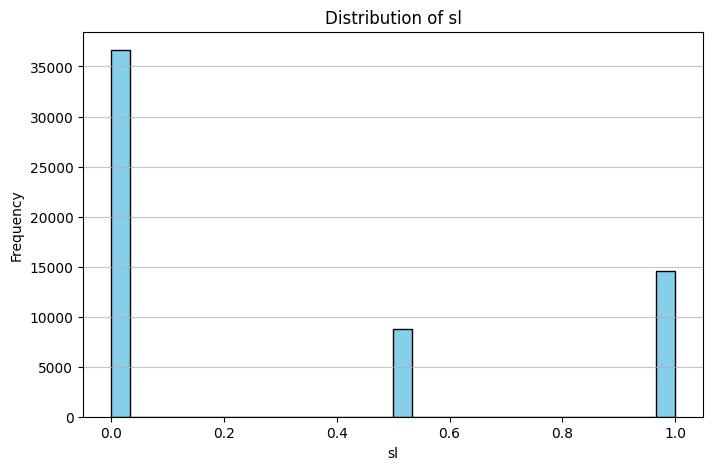

In [20]:
import pandas as pd

parallel_softlabels_path = "/dccstor/gma2/jhjenny9/search-and-learn/data/sl/parallel/softlabels_parallel_df.csv"

# Read the CSV file
parallel_softlabels_df = pd.read_csv(parallel_softlabels_path)

# Show the first few lines
print(parallel_softlabels_df.head())

# Show the shape of the DataFrame
print(parallel_softlabels_df.shape)

print(parallel_softlabels_df['problem'].unique().shape)

import matplotlib.pyplot as plt

# Plot the distribution of the 'sl' column
plt.figure(figsize=(8, 5))
plt.hist(parallel_softlabels_df['sl'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of sl')
plt.xlabel('sl')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()



In [40]:
# Rename columns to simplify names (e.g., sl_weighted_2_softlabels_4 -> sl_weighted_4)
rename_columns = {
    f"sl_weighted_2_softlabels_4": "sl_weighted_4",
    f"sl_naive_2_softlabels_4": "sl_naive_4",
    f"sl_maj_2_softlabels_4": "sl_maj_4",
    f"sl_weighted_2_softlabels_8": "sl_weighted_8",
    f"sl_naive_2_softlabels_8": "sl_naive_8",
    f"sl_maj_2_softlabels_8": "sl_maj_8",
    f"sl_weighted_2_softlabels_16": "sl_weighted_16",
    f"sl_naive_2_softlabels_16": "sl_naive_16",
    f"sl_maj_2_softlabels_16": "sl_maj_16",
    f"sl_weighted_2_softlabels_32": "sl_weighted_32",
    f"sl_naive_2_softlabels_32": "sl_naive_32",
    f"sl_maj_2_softlabels_32": "sl_maj_32",
}

# Apply renaming
merged_df.rename(columns=rename_columns, inplace=True)


In [41]:
merged_df.tail()

,problem,sl_weighted_2,sl_naive_2,sl_maj_2,sl_weighted_4,sl_naive_4,sl_maj_4,sl_weighted_8,sl_naive_8,sl_maj_8,sl_weighted_16,sl_naive_16,sl_maj_16,sl_weighted_32,sl_naive_32,sl_maj_32
495,What is the domain of the function $f(x) = \fr...,0.24,0.24,0.12,0.22,0.24,0.08,0.26,0.40,0.08,0.22,0.58,0.00,0.02,0.26,0.00
496,Let $z = 1+i$ and $w = \dfrac{3z+1}{5z+7}$. Fi...,0.74,0.74,0.52,0.76,0.76,0.68,0.94,0.90,0.90,1.00,0.96,1.00,1.00,1.00,1.00
497,An equiangular octagon has four sides of lengt...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
498,A sequence $(a_n)$ is defined as follows:\n\[a...,0.14,0.14,0.12,0.22,0.22,0.16,0.30,0.20,0.18,0.40,0.16,0.30,0.68,0.50,0.30
499,Altitudes $\overline{AD}$ and $\overline{BE}$ ...,0.56,0.56,0.38,0.74,0.82,0.56,0.90,0.96,0.80,0.96,0.84,0.92,1.00,0.72,0.96


In [42]:
## Save the merged DataFrame to a CSV file
output_file = "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/merged_softlabels.csv"
merged_df.to_csv(output_file, index=False)
print(f"Merged DataFrame saved to {output_file}")

Merged DataFrame saved to /dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/merged_softlabels.csv


### Load in scores and outputs from BoN (up to 32)

In [43]:
# Load and process the .jsonl file
def load_jsonl_extract_accuracy(jsonl_path):
    data = []

    with open(jsonl_path, "r") as f:
        for line in f:
            entry = json.loads(line)
            question = entry["problem"]
            score_list = entry["agg_scores"] 
            completion_tokens = entry["completion_tokens"]
            indicator_weighted_1 = entry["indicator_weighted@1"]
            indicator_naive_1 = entry["indicator_naive@1"]
            indicator_maj_1 = entry["indicator_maj@1"]
            indicator_weighted_2 = entry["indicator_weighted@2"]
            indicator_naive_2 = entry["indicator_naive@2"]
            indicator_maj_2 = entry["indicator_maj@2"]
            indicator_weighted_4 = entry["indicator_weighted@4"]
            indicator_naive_4 = entry["indicator_naive@4"]
            indicator_maj_4 = entry["indicator_maj@4"]
            indicator_weighted_8 = entry["indicator_weighted@8"]
            indicator_naive_8 = entry["indicator_naive@8"]
            indicator_maj_8 = entry["indicator_maj@8"]
            indicator_weighted_16 = entry["indicator_weighted@16"]
            indicator_naive_16 = entry["indicator_naive@16"]
            indicator_maj_16 = entry["indicator_maj@16"]
            indicator_weighted_32 = entry["indicator_weighted@32"]
            indicator_naive_32 = entry["indicator_naive@32"]
            indicator_maj_32 = entry["indicator_maj@32"]
            correctness_1 = entry["correctness@1"]
            correctness_2 = entry["correctness@2"]
            correctness_4 = entry["correctness@4"]
            correctness_8 = entry["correctness@8"]
            correctness_16 = entry["correctness@16"]
            correctness_32 = entry["correctness@32"]
            data.append({
                "question": question,
                "score": score_list,
                "score_list": score_list,
                "completion_tokens": completion_tokens,
                "indicator_weighted_1": indicator_weighted_1,
                "indicator_naive_1": indicator_naive_1,
                "indicator_maj_1": indicator_maj_1,
                "indicator_weighted_2": indicator_weighted_2,
                "indicator_naive_2": indicator_naive_2,
                "indicator_maj_2": indicator_maj_2,
                "indicator_weighted_4": indicator_weighted_4,
                "indicator_naive_4": indicator_naive_4,
                "indicator_maj_4": indicator_maj_4,
                "indicator_weighted_8": indicator_weighted_8,
                "indicator_naive_8": indicator_naive_8,
                "indicator_maj_8": indicator_maj_8,
                "indicator_weighted_16": indicator_weighted_16,
                "indicator_naive_16": indicator_naive_16,
                "indicator_maj_16": indicator_maj_16, # indicator for correctness of maj at 16 generations.
                "indicator_weighted_32": indicator_weighted_32,
                "indicator_naive_32": indicator_naive_32,
                "indicator_maj_32": indicator_maj_32,
                "correctness_1": correctness_1,
                "correctness_2": correctness_2,
                "correctness_4": correctness_4,
                "correctness_8": correctness_8,
                "correctness_16": correctness_16, 
                 "correctness_32": correctness_32, # list of whether each of 32 generations is correct or not.
            })

    return pd.DataFrame(data)

In [48]:
df_bon = load_jsonl_extract_accuracy("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/parallel_best_of_32/best_of_n_completions.jsonl")

In [49]:
df_bon.shape

(500, 28)

In [59]:
# add column for question index.
df_bon["sb_idx"] = df_bon.index.tolist()

In [60]:
df_bon.columns

Index(['question', 'score', 'score_list', 'completion_tokens',
       'indicator_weighted_1', 'indicator_naive_1', 'indicator_maj_1',
       'indicator_weighted_2', 'indicator_naive_2', 'indicator_maj_2',
       'indicator_weighted_4', 'indicator_naive_4', 'indicator_maj_4',
       'indicator_weighted_8', 'indicator_naive_8', 'indicator_maj_8',
       'indicator_weighted_16', 'indicator_naive_16', 'indicator_maj_16',
       'indicator_weighted_32', 'indicator_naive_32', 'indicator_maj_32',
       'correctness_1', 'correctness_2', 'correctness_4', 'correctness_8',
       'correctness_16', 'correctness_32', 'sb_idx'],
      dtype='object')

### Join soft labels with BoN features.

In [63]:
# rename problem to question
merged_df.rename(columns={"problem": "question"}, inplace=True)
merged_df
# join with df_bon keeping all columns from both dataframes
data_w_softlabels = merged_df.merge(df_bon, on="question", how="left")
data_w_softlabels

,question,sl_weighted_2,sl_naive_2,sl_maj_2,sl_weighted_4,sl_naive_4,sl_maj_4,sl_weighted_8,sl_naive_8,sl_maj_8,...,indicator_weighted_32,indicator_naive_32,indicator_maj_32,correctness_1,correctness_2,correctness_4,correctness_8,correctness_16,correctness_32,sb_idx
0,"Convert the point $(0,3)$ in rectangular coord...",0.64,0.64,0.44,0.58,0.74,0.54,0.66,0.76,0.68,...,1,1,1,[True],"[True, False]","[True, False, True, False]","[True, False, True, False, True, True, True, T...","[True, False, True, False, True, True, True, T...","[True, False, True, False, True, True, True, T...",0
1,Define\n\[p = \sum_{k = 1}^\infty \frac{1}{k^2...,0.30,0.30,0.16,0.34,0.42,0.24,0.50,0.66,0.30,...,0,0,0,[False],"[False, False]","[False, False, False, False]","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",1
2,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...",0.92,0.92,0.74,0.98,0.96,0.98,0.98,0.90,0.98,...,1,1,1,[True],"[True, True]","[True, True, True, True]","[True, True, True, True, False, True, True, True]","[True, True, True, True, False, True, True, Tr...","[True, True, True, True, False, True, True, Tr...",2
3,How many positive whole-number divisors does 1...,0.92,0.92,0.92,1.00,0.98,1.00,1.00,1.00,1.00,...,1,1,1,[True],"[True, True]","[True, True, True, True]","[True, True, True, True, True, False, True, True]","[True, True, True, True, True, False, True, Tr...","[True, True, True, True, True, False, True, Tr...",3
4,The results of a cross-country team's training...,0.64,0.64,0.36,0.66,0.66,0.62,0.78,0.58,0.74,...,1,0,1,[True],"[True, True]","[True, True, False, False]","[True, True, False, False, False, False, False...","[True, True, False, False, False, False, False...","[True, True, False, False, False, False, False...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,What is the domain of the function $f(x) = \fr...,0.24,0.24,0.12,0.22,0.24,0.08,0.26,0.40,0.08,...,0,0,0,[False],"[False, False]","[False, False, False, False]","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",495
496,Let $z = 1+i$ and $w = \dfrac{3z+1}{5z+7}$. Fi...,0.74,0.74,0.52,0.76,0.76,0.68,0.94,0.90,0.90,...,1,1,1,[False],"[False, False]","[False, False, True, True]","[False, False, True, True, True, False, False,...","[False, False, True, True, True, False, False,...","[False, False, True, True, True, False, False,...",496
497,An equiangular octagon has four sides of lengt...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,[False],"[False, False]","[False, False, False, False]","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",497
498,A sequence $(a_n)$ is defined as follows:\n\[a...,0.14,0.14,0.12,0.22,0.22,0.16,0.30,0.20,0.18,...,1,1,0,[False],"[False, False]","[False, False, False, True]","[False, False, False, True, False, False, Fals...","[False, False, False, True, False, False, Fals...","[False, False, False, True, False, False, Fals...",498


In [64]:
data_w_softlabels.columns

Index(['question', 'sl_weighted_2', 'sl_naive_2', 'sl_maj_2', 'sl_weighted_4',
       'sl_naive_4', 'sl_maj_4', 'sl_weighted_8', 'sl_naive_8', 'sl_maj_8',
       'sl_weighted_16', 'sl_naive_16', 'sl_maj_16', 'sl_weighted_32',
       'sl_naive_32', 'sl_maj_32', 'score', 'score_list', 'completion_tokens',
       'indicator_weighted_1', 'indicator_naive_1', 'indicator_maj_1',
       'indicator_weighted_2', 'indicator_naive_2', 'indicator_maj_2',
       'indicator_weighted_4', 'indicator_naive_4', 'indicator_maj_4',
       'indicator_weighted_8', 'indicator_naive_8', 'indicator_maj_8',
       'indicator_weighted_16', 'indicator_naive_16', 'indicator_maj_16',
       'indicator_weighted_32', 'indicator_naive_32', 'indicator_maj_32',
       'correctness_1', 'correctness_2', 'correctness_4', 'correctness_8',
       'correctness_16', 'correctness_32', 'sb_idx'],
      dtype='object')

In [65]:
# create pivot table.

# Columns to melt (soft labels)
sl_cols = [
    # "indicator_weighted_1", "indicator_naive_1", "indicator_maj_1",
    # "indicator_weighted_2", "indicator_naive_2", "indicator_maj_2",
    # "indicator_weighted_4", "indicator_naive_4", "indicator_maj_4",
    # "indicator_weighted_8", "indicator_naive_8", "indicator_maj_8",
    # "indicator_weighted_16", "indicator_naive_16", "indicator_maj_16",
    # "indicator_weighted_32", "indicator_naive_32", "indicator_maj_32",
    "sl_weighted_2", "sl_naive_2", "sl_maj_2",
    "sl_weighted_4", "sl_naive_4", "sl_maj_4",
    "sl_weighted_8", "sl_naive_8", "sl_maj_8",
    "sl_weighted_16", "sl_naive_16", "sl_maj_16",
    "sl_weighted_32", "sl_naive_32", "sl_maj_32",
]

# Melt the dataframe from wide to long
predictor_df = data_w_softlabels.melt(
    id_vars=['question', 'score', 'completion_tokens', 'sb_idx'], # , 'correctness_32'
    value_vars=sl_cols,
    var_name='method_N',
    value_name='sl'
) # indicator: whether the final answer is correct.

# # Extract method and N from 'method_N'
predictor_df[['drop', 'method', 'N']] = predictor_df['method_N'].str.extract(r'(sl)_(\w+?)_(\d+)')
predictor_df.drop(columns=['method_N', 'drop'], inplace=True)

# Convert N to integer
predictor_df['N'] = predictor_df['N'].astype(int)

# Show result
predictor_df.head()

,question,score,completion_tokens,sb_idx,sl,method,N
0,"Convert the point $(0,3)$ in rectangular coord...","[1.0, 0.169921875, 1.0, 0.361328125, 1.0, 1.0,...","[271, 290, 269, 220, 220, 403, 261, 310, 260, ...",0,0.64,weighted,2
1,Define\n\[p = \sum_{k = 1}^\infty \frac{1}{k^2...,"[0.640625, 0.98046875, 0.0030822754, 1.0, 0.12...","[1064, 872, 964, 654, 831, 680, 1384, 832, 103...",1,0.30,weighted,2
2,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[432, 256, 460, 509, 505, 462, 437, 512, 360, ...",2,0.92,weighted,2
3,How many positive whole-number divisors does 1...,"[0.9921875, 1.0, 1.0, 0.9921875, 1.0, 0.90625,...","[441, 382, 489, 163, 415, 248, 250, 251, 354, ...",3,0.92,weighted,2
4,The results of a cross-country team's training...,"[0.9609375, 0.99609375, 0.99609375, 0.9921875,...","[476, 307, 330, 468, 781, 203, 427, 746, 340, ...",4,0.64,weighted,2


In [66]:
predictor_df.columns

Index(['question', 'score', 'completion_tokens', 'sb_idx', 'sl', 'method',
       'N'],
      dtype='object')

In [67]:
### change completion_tokens froms str --> a list of ints.
predictor_df["completion_tokens"] = predictor_df["completion_tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [1]:
# Compute length of question (aka, length of the string)
predictor_df["question_length"] = predictor_df["question"].str.len()
# Compute token count from completion_tokens
# predictor_df["token_count"] = predictor_df["completion_tokens"].apply(sum)
# turn completion tokens into a list of ints.
predictor_df["completion_tokens"] = predictor_df["completion_tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Obtain Token Count for Best of N.
predictor_df["token_count"] = predictor_df.apply(lambda row: sum(row["completion_tokens"][:row["N"]]), axis=1)
predictor_df = pd.get_dummies(predictor_df, columns=["method"])

NameError: name 'predictor_df' is not defined

In [69]:
predictor_df.shape

(7500, 11)

In [72]:
# Transform method columns into a single 'method' column.

def decode_method(row):
    if row["method_maj"]:
        return "majority"
    elif row["method_naive"]:
        return "naive"
    elif row["method_weighted"]:
        return "weighted"
    elif row["method_beam_search"]:
        return "beam_search"
    else:
        return "unknown"

# Apply the function row-wise
predictor_df["method"] = predictor_df.apply(decode_method, axis=1)

In [73]:
predictor_df

,question,score,completion_tokens,sb_idx,sl,N,question_length,token_count,method_maj,method_naive,method_weighted,method
0,"Convert the point $(0,3)$ in rectangular coord...","[1.0, 0.169921875, 1.0, 0.361328125, 1.0, 1.0,...","[271, 290, 269, 220, 220, 403, 261, 310, 260, ...",0,0.64,2,161,561,False,False,True,weighted
1,Define\n\[p = \sum_{k = 1}^\infty \frac{1}{k^2...,"[0.640625, 0.98046875, 0.0030822754, 1.0, 0.12...","[1064, 872, 964, 654, 831, 680, 1384, 832, 103...",1,0.30,2,217,1936,False,False,True,weighted
2,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[432, 256, 460, 509, 505, 462, 437, 512, 360, ...",2,0.92,2,113,688,False,False,True,weighted
3,How many positive whole-number divisors does 1...,"[0.9921875, 1.0, 1.0, 0.9921875, 1.0, 0.90625,...","[441, 382, 489, 163, 415, 248, 250, 251, 354, ...",3,0.92,2,54,823,False,False,True,weighted
4,The results of a cross-country team's training...,"[0.9609375, 0.99609375, 0.99609375, 0.9921875,...","[476, 307, 330, 468, 781, 203, 427, 746, 340, ...",4,0.64,2,731,783,False,False,True,weighted
...,...,...,...,...,...,...,...,...,...,...,...,...
7495,What is the domain of the function $f(x) = \fr...,"[0.0200195312, 0.9765625, 0.0074462891, 0.9765...","[596, 334, 387, 509, 499, 396, 424, 227, 283, ...",495,0.00,32,166,13616,True,False,False,majority
7496,Let $z = 1+i$ and $w = \dfrac{3z+1}{5z+7}$. Fi...,"[0.361328125, 0.33203125, 0.2412109375, 1.0, 1...","[463, 314, 460, 630, 438, 259, 427, 456, 794, ...",496,1.00,32,55,14374,True,False,False,majority
7497,An equiangular octagon has four sides of lengt...,"[0.0407714844, 0.98046875, 0.29296875, 0.99218...","[180, 483, 373, 649, 312, 507, 443, 408, 337, ...",497,0.00,32,195,16202,True,False,False,majority
7498,A sequence $(a_n)$ is defined as follows:\n\[a...,"[0.28125, 0.99609375, 0.0142822266, 0.98828125...","[957, 946, 967, 900, 1388, 467, 845, 935, 618,...",498,0.30,32,125,27588,True,False,False,majority


In [74]:
# save to csv.
output_file = "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/softlabel_predictor_df.csv"
predictor_df.to_csv(output_file, index=False)

# read don_df with softlabels.
predictor_df = pd.read_csv(output_file)
predictor_df.head()

,question,score,completion_tokens,sb_idx,sl,N,question_length,token_count,method_maj,method_naive,method_weighted,method
0,"Convert the point $(0,3)$ in rectangular coord...","[1.0, 0.169921875, 1.0, 0.361328125, 1.0, 1.0,...","[271, 290, 269, 220, 220, 403, 261, 310, 260, ...",0,0.64,2,161,561,False,False,True,weighted
1,Define\n\[p = \sum_{k = 1}^\infty \frac{1}{k^2...,"[0.640625, 0.98046875, 0.0030822754, 1.0, 0.12...","[1064, 872, 964, 654, 831, 680, 1384, 832, 103...",1,0.30,2,217,1936,False,False,True,weighted
2,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[432, 256, 460, 509, 505, 462, 437, 512, 360, ...",2,0.92,2,113,688,False,False,True,weighted
3,How many positive whole-number divisors does 1...,"[0.9921875, 1.0, 1.0, 0.9921875, 1.0, 0.90625,...","[441, 382, 489, 163, 415, 248, 250, 251, 354, ...",3,0.92,2,54,823,False,False,True,weighted
4,The results of a cross-country team's training...,"[0.9609375, 0.99609375, 0.99609375, 0.9921875,...","[476, 307, 330, 468, 781, 203, 427, 746, 340, ...",4,0.64,2,731,783,False,False,True,weighted


In [27]:
predictor_df[predictor_df["N"] == 32].shape

(75, 11)

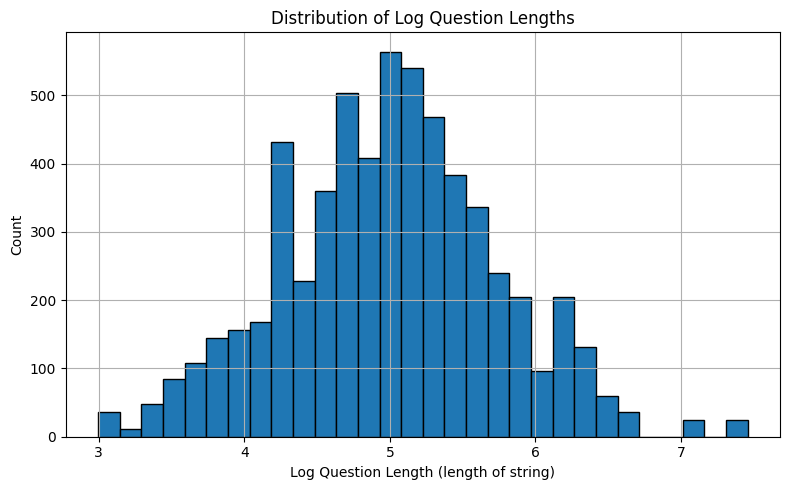

In [25]:
import matplotlib.pyplot as plt

# Create histogram
plt.figure(figsize=(8, 5))
plt.hist(np.log(predictor_df["question_length"]), bins=30, edgecolor='black')

plt.xlabel("Log Question Length (length of string)")
plt.ylabel("Count")
plt.title("Distribution of Log Question Lengths")
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

### Plots of Accuracy

In [10]:
N_val = [1, 2, 4, 8, 16, 32]
mv_accuracy = np.mean(df_N8["indicator_maj_1"]), np.mean(df_N8["indicator_maj_2"]), np.mean(df_N8["indicator_maj_4"]), np.mean(df_N8["indicator_maj_8"]), np.mean(df_N8["indicator_maj_16"]), np.mean(df_N8["indicator_maj_32"])
BoN_vanilla_accuracy = np.mean(df_N8["indicator_naive_1"]), np.mean(df_N8["indicator_naive_2"]), np.mean(df_N8["indicator_naive_4"]), np.mean(df_N8["indicator_naive_8"]), np.mean(df_N8["indicator_naive_16"]), np.mean(df_N8["indicator_naive_32"])
BoN_weighted_accuracy = np.mean(df_N8["indicator_weighted_1"]), np.mean(df_N8["indicator_weighted_2"]), np.mean(df_N8["indicator_weighted_4"]), np.mean(df_N8["indicator_weighted_8"]), np.mean(df_N8["indicator_weighted_16"]), np.mean(df_N8["indicator_weighted_32"])
df_accuracy = pd.DataFrame({
    "N": N_val,
    "majority_vote": mv_accuracy,
    "BoN_vanilla": BoN_vanilla_accuracy,
    "BoN_weighted": BoN_weighted_accuracy
})

In [11]:
df_accuracy.head()

,N,majority_vote,BoN_vanilla,BoN_weighted
0,1,0.388,0.388,0.388
1,2,0.388,0.474,0.474
2,4,0.470,0.520,0.526
3,8,0.552,0.558,0.582
4,16,0.594,0.586,0.636


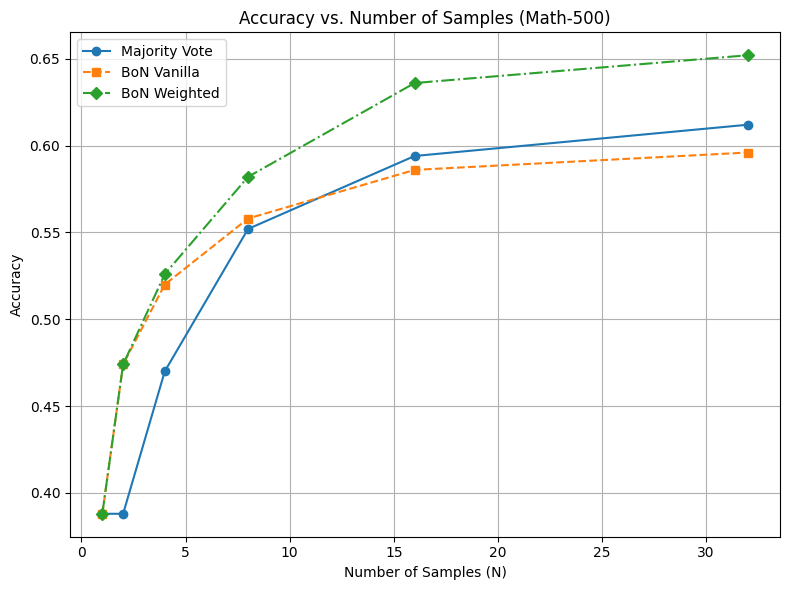

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Create scatter plot of accuracy vs. number of samples
plt.figure(figsize=(8, 6))
plt.plot(df_accuracy["N"], df_accuracy["majority_vote"], 'o-', label="Majority Vote")
plt.plot(df_accuracy["N"], df_accuracy["BoN_vanilla"], 's--', label="BoN Vanilla")
plt.plot(df_accuracy["N"], df_accuracy["BoN_weighted"], 'D-.', label="BoN Weighted")

# Formatting
plt.xlabel("Number of Samples (N)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Samples (Math-500)")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("accuracy_vs_N_Math500_Bo32.png", dpi=300)
plt.show()

In [78]:
# save to csv.
output_file = "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/softlabel_predictor_df.csv"
# predictor_df.to_csv(output_file, index=False)

# read df.
predictor_df = pd.read_csv(output_file)

#### Add Latency Measurements.

In [9]:
# read in the latencies df.
latencies_df = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/scripts/latencies_df.csv")
latencies_df.head()

,sb_idx,N,method,time
0,0,1,majority,1.52
1,0,1,naive,2.37
2,0,1,weighted,2.37
3,0,2,majority,2.13
4,0,2,naive,3.56


In [ ]:
method_columns = ["method_maj", "method_naive", "method_weighted"]
# Use idxmax to find which column has the value 1 for each row
predictor_df["method"] = predictor_df[method_columns].idxmax(axis=1)
# Optional: clean up the method names by removing the prefix
predictor_df["method"] = predictor_df["method"].str.replace("method_", "")
# renaming.
predictor_df["method"] = predictor_df["method"].replace("maj", "majority")
# Drop the one-hot columns if you no longer need them
# df.drop(columns=method_columns, inplace=True)

In [82]:
# Combine the columns df_test and latencies_for_df_test.
predictor_df = predictor_df.merge(
    latencies_df,
    on=["sb_idx", "N", "method"],
    how="left"
)

In [84]:
predictor_df.columns

Index(['question', 'score', 'score_list', 'completion_tokens', 'sb_idx',
       'correctness_1', 'correctness_2', 'correctness_4', 'correctness_8',
       'correctness_16', 'sl', 'N', 'question_length', 'token_count',
       'method_maj', 'method_naive', 'method_weighted', 'method', 'time'],
      dtype='object')

## 

### Prepare Features for Difficulty Probe.

In [5]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from transformers import BertTokenizer, BertModel

/dccstor/gma2/jhjenny9/envs/model_serve/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA available: False
CUDA device name: No GPU


### Qwen Embeddings

In [10]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
# Load the model and tokenizer
model_name = "Qwen/Qwen2.5-1.5B-Instruct" # to try: quantized mode.
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)

/dccstor/gma2/jhjenny9/envs/model_serve/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Tokenize the question
question = "What is the square root of 144?"
inputs = tokenizer(question, return_tensors="pt")
input_ids = inputs["input_ids"].to(device)

In [9]:
# Forward pass to get hidden states
with torch.no_grad():
    outputs = model(input_ids=input_ids, output_hidden_states=True, return_dict=True)

In [10]:
# Extract the last token for the embedding
embedding = outputs.hidden_states[-1][:, -1, :]  # shape: [1, hidden_dim]

In [11]:
embedding.squeeze().numpy(), len(embedding.squeeze().numpy())

(array([-1.4930087 , -0.23919553,  3.452469  , ...,  5.2529936 ,
        -2.0497942 ,  6.2926364 ], dtype=float32),
 1536)

turn questions into embeddings.

In [8]:
def get_embedding(text, model, tokenizer, device="cpu"):
    """
    Extracts an embedding from the last token of the last hidden layer
    for a given input text.
    
    Args:
        text (str): Input query
        model (PreTrainedModel): Qwen model
        tokenizer (PreTrainedTokenizer): Corresponding tokenizer
        device (str): Device to run on ("cuda" or "cpu")
    
    Returns:
        np.ndarray: Embedding vector of shape (hidden_dim,)
    """
    # Tokenize the input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    input_ids = inputs["input_ids"].to(device)

    # Run the model to get hidden states
    with torch.no_grad():
        outputs = model(input_ids=input_ids, output_hidden_states=True, return_dict=True)

    # Extract last token embedding from the last hidden layer
    last_hidden_state = outputs.hidden_states[-1]  # shape: [1, seq_len, hidden_dim]
    embedding = last_hidden_state[:, -1, :]        # shape: [1, hidden_dim]

    return embedding.squeeze().cpu().numpy()

Qwen 2.5B embedding is of dimension 1536.

In [7]:
local_model_path = "/u/jhjenny9/.cache/huggingface/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594"
tokenizer = BertTokenizer.from_pretrained(local_model_path)
model = BertModel.from_pretrained(local_model_path).to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [147]:
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # CLS token is at position 0
    return cls_embedding.squeeze().numpy()

In [59]:
# Create train/test split based on 'sb_idx' (query identifier)
from sklearn.model_selection import train_test_split

unique_sb_idx = predictor_df['sb_idx'].unique()

# Split sb_idx into train/test
sb_idx_train, sb_idx_test = train_test_split(
    unique_sb_idx,
    test_size=0.20, # .15
    random_state=6
)

# Divide queries (represented by sb_idx) into train and test
df_train = predictor_df[predictor_df['sb_idx'].isin(sb_idx_train)].reset_index(drop=True)
df_test = predictor_df[predictor_df['sb_idx'].isin(sb_idx_test)].reset_index(drop=True)

In [ ]:
# (Training Data) Extract features: CLS + decoding parameters
# Load the model and tokenizer
model_name = "Qwen/Qwen2.5-1.5B-Instruct" # to try: quantized mode.
qwen = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

cls_features = []

## Scaling factors
NUM_SAMPLES_SCALE = 1.0 
QUESTION_LENGTH_SCALE = 1.0
METHOD_SCALE = 1.0

for _, row in df_train.iterrows():
    if _ % 100 == 0:
        print('Processing question number:', _, 'out of', len(df_train))
    # cls_vec = get_cls_embedding(row["question"])  # e.g., shape (768,)
    cls_vec = get_embedding(row["question"], qwen, tokenizer)  # e.g., shape (1536,)
    # Scalar features
    num_samples = row["N"] * NUM_SAMPLES_SCALE
    question_length = np.log(row["question_length"]) * QUESTION_LENGTH_SCALE
    method_maj = row["method_maj"] * METHOD_SCALE
    method_naive = row["method_naive"] * METHOD_SCALE
    method_weighted = row["method_weighted"] * METHOD_SCALE

    # Concatenate features
    features = np.concatenate([
        cls_vec, 
        [num_samples, question_length, method_maj, method_naive, method_weighted]
    ]) 

    cls_features.append(features)

Processing question number: 0 out of 4800
Processing question number: 100 out of 4800
Processing question number: 200 out of 4800
Processing question number: 300 out of 4800
Processing question number: 400 out of 4800
Processing question number: 500 out of 4800
Processing question number: 600 out of 4800
Processing question number: 700 out of 4800
Processing question number: 800 out of 4800
Processing question number: 900 out of 4800
Processing question number: 1000 out of 4800
Processing question number: 1100 out of 4800
Processing question number: 1200 out of 4800
Processing question number: 1300 out of 4800
Processing question number: 1400 out of 4800
Processing question number: 1500 out of 4800
Processing question number: 1600 out of 4800
Processing question number: 1700 out of 4800
Processing question number: 1800 out of 4800
Processing question number: 1900 out of 4800
Processing question number: 2000 out of 4800
Processing question number: 2100 out of 4800
Processing question nu

In [22]:
X_train = np.array(cls_features)
y_train = df_train["sl"].values

In [23]:
X_train.shape, y_train.shape

((4800, 1541), (4800,))

In [19]:
# save 
#  np.save("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/qwen_X_train.npy", X_train)



X_train = np.load("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/qwen_X_train.npy")
y_train = np.load("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/softlabel_y_train.npy")

In [ ]:
# save softlabel X_train, y_train
# np.save("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/softlabel_X_train.npy", X_train)
# np.save("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/softlabel_y_train.npy", y_train)

# load softlabel X_train, y_train
# X_train = np.load("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/softlabel_X_train.npy")
# y_train = np.load("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/softlabel_y_train.npy")

### Plotting Feature Importance.

In [20]:
# split high-dimensional CLS and interpretable features
cls_dim = 1536 # 768 # len(cls_vec)
cls_part = X_train[:, :cls_dim]
named_features = pd.DataFrame(
    X_train[:, cls_dim:],  # shape (n_samples, 5)
    columns=["num_samples", "question_length", "method_maj", "method_naive","method_weighted"] # , "method_weighted"
)

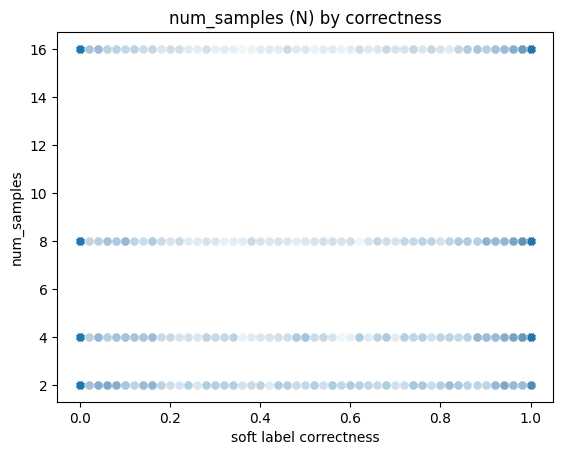

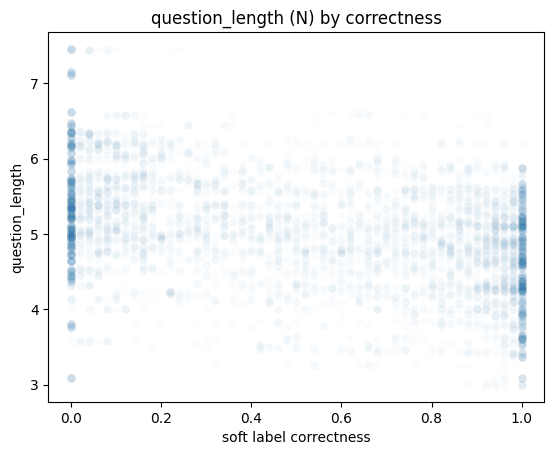

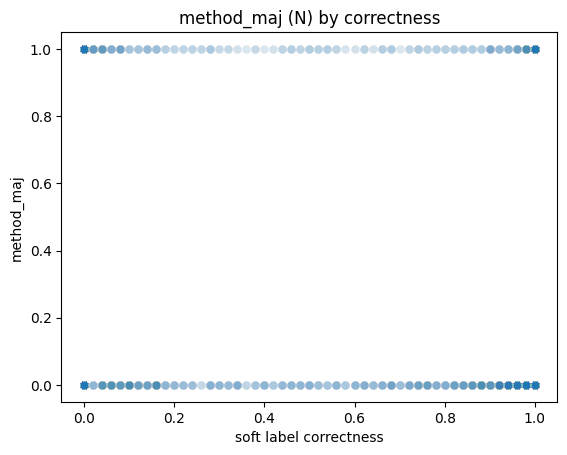

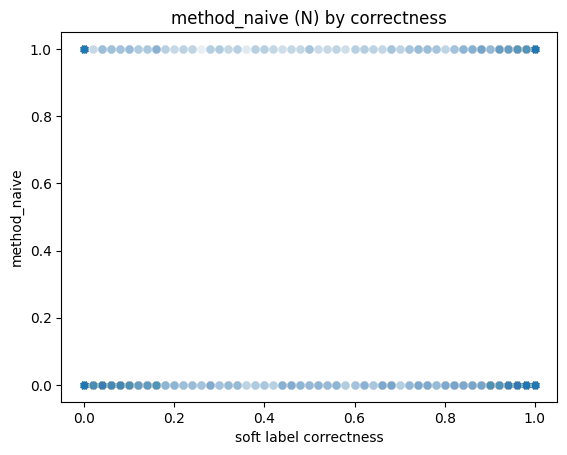

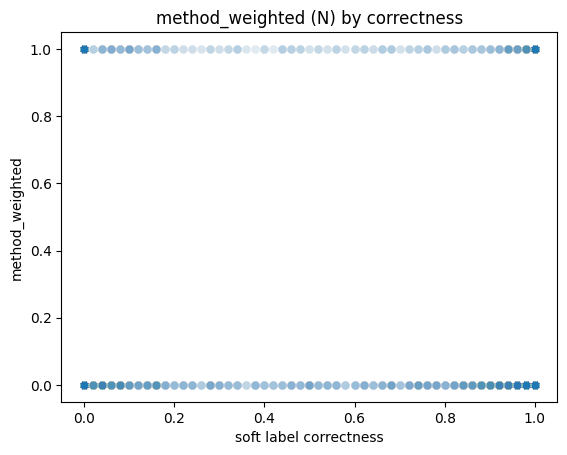

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in named_features.columns:
    sns.scatterplot(x=y_train, y=named_features[col], alpha=0.02)
    plt.title(f"{col} (N) by correctness")
    plt.xlabel("soft label correctness")
    plt.ylabel(col)
    plt.show()

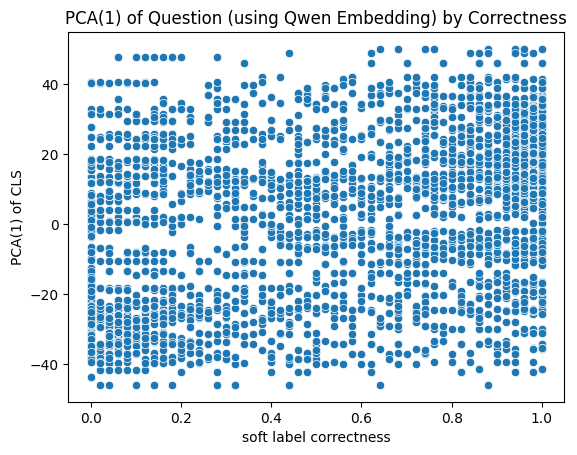

In [22]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Reduce to 1D or 2D
pca = PCA(n_components=1)
cls_1d = pca.fit_transform(cls_part)[:, 0]

# Plot 1D PCA of CLS
sns.scatterplot(x=y_train, y=cls_1d)
plt.title("PCA(1) of Question (using Qwen Embedding) by Correctness")
plt.xlabel("soft label correctness")
plt.ylabel("PCA(1) of CLS")
plt.show()

### Create Testing Data

In [ ]:
# (Testing Data) Extract features: CLS + decoding parameters
cls_features = []

NUM_SAMPLES_SCALE = 1.0
QUESTION_LENGTH_SCALE = 1.0
METHOD_SCALE = 1.0

for _, row in df_test.iterrows(): 
    # print the question number every 100 question
    if _ % 100 == 0:
        print('Processing question number:', _, 'out of', len(df_test))
    # cls_vec = get_cls_embedding(row["question"])  # e.g., shape (768,)
    cls_vec = get_embedding(row["question"], qwen, tokenizer)  # e.g., shape (1536,)
    
    # Scalar features
    num_samples = row["N"] * NUM_SAMPLES_SCALE
    question_length = np.log(row["question_length"]) * QUESTION_LENGTH_SCALE
    method_maj = row["method_maj"] * METHOD_SCALE
    method_naive = row["method_naive"] * METHOD_SCALE
    method_weighted = row["method_weighted"] * METHOD_SCALE

    # Concatenate features
    features = np.concatenate([cls_vec, [num_samples, question_length, method_maj, method_naive, method_weighted]])
    cls_features.append(features)


Processing question number: 0 out of 1200
Processing question number: 100 out of 1200
Processing question number: 200 out of 1200
Processing question number: 300 out of 1200
Processing question number: 400 out of 1200
Processing question number: 500 out of 1200
Processing question number: 600 out of 1200
Processing question number: 700 out of 1200
Processing question number: 800 out of 1200
Processing question number: 900 out of 1200
Processing question number: 1000 out of 1200
Processing question number: 1100 out of 1200


In [16]:
X_test = np.array(cls_features)
y_test = df_test["sl"].values

In [33]:
# np.save("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/qwen_X_test.npy", X_test)

X_test = np.load("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/qwen_X_test.npy")
y_test = np.load("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/softlabel_y_test.npy")

In [ ]:
# save softlabel X_test, y_test
# np.save("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/softlabel_X_test.npy", X_test)
# np.save("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/softlabel_y_test.npy", y_test)

# load softlabel X_test, y_test
# X_test = np.load("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/softlabel_X_test.npy")
# y_test = np.load("/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/softlabel_y_test.npy")

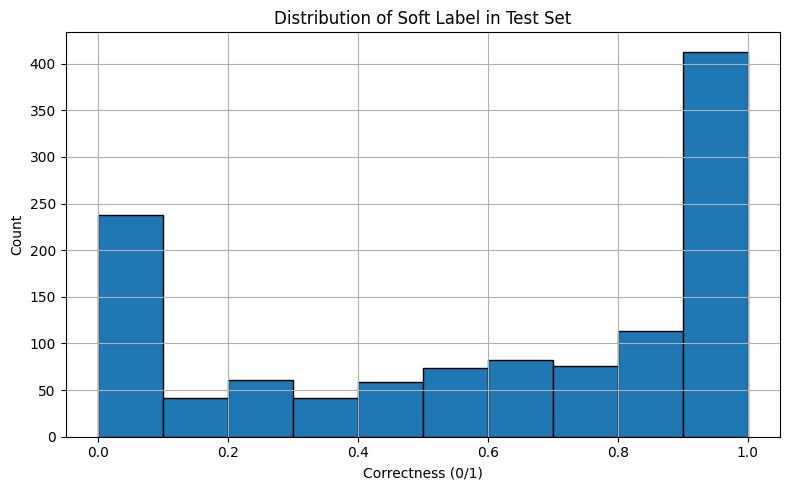

In [24]:
# histogram of y_test.
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(y_test, bins=10, edgecolor='black')
plt.xlabel("Correctness (0/1)")
plt.ylabel("Count")
plt.title("Distribution of Soft Label in Test Set")
plt.grid(True)
plt.tight_layout()


In [154]:
y_test.mean(), y_train.mean()

(0.5955166666666666, 0.5090083333333334)

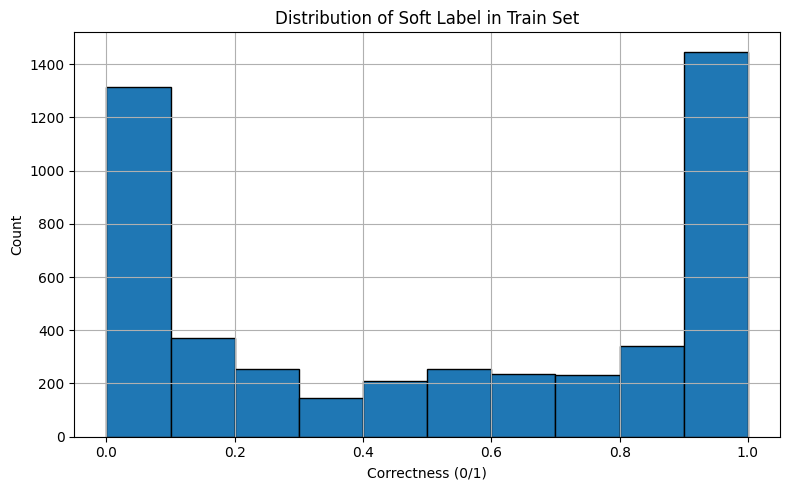

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(y_train, bins=10, edgecolor='black')
plt.xlabel("Correctness (0/1)")
plt.ylabel("Count")
plt.title("Distribution of Soft Label in Train Set")
plt.grid(True)
plt.tight_layout()

In [ ]:
### Consider Changing to Llama embedding (what is the SOTA on embedding models for reasoning), RoBERTa (trained on much more data).
### Last layer of generator model as the embedding. Qwen is trained on reasoning data, so it might be a good embedding model?
### SOTA embedding models: Qwen2.5-1.5B embedding model, one specialized and one LLM-based embedding from a model that is good enough.

### Train MLP.

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

In [31]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [32]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4800, 1541), (4800,), (1200, 1541), (1200,))

### SKLearn MLPClassifier

In [110]:
# # 2-layer MLP Binary Classifier
# mlp_clf = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', max_iter=500, random_state=42)
# mlp_clf.fit(X_train, y_train)
# y_pred = mlp_clf.predict(X_test)
# acc = accuracy_score(y_test, y_pred)

model = MLPRegressor(hidden_layer_sizes=(128,64), activation='relu', max_iter=500)
model.fit(X_train, y_train)


# Predict probabilities (between 0 and 1)
y_pred = model.predict(X_test)

/dccstor/gma2/jhjenny9/envs/model_serve/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:787: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


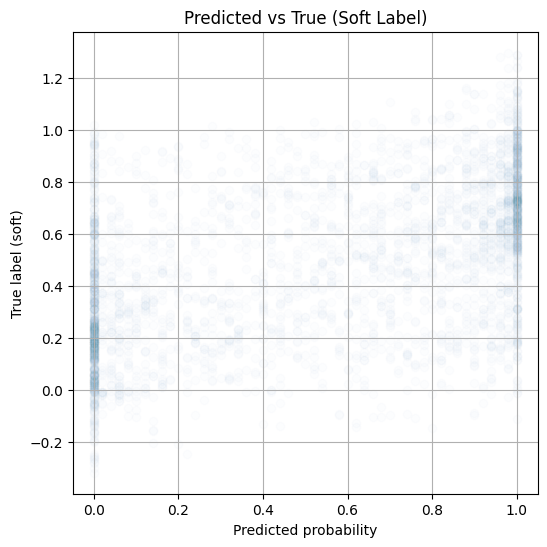

In [146]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.01)
plt.xlabel("Predicted probability")
plt.ylabel("True label (soft)")
plt.title("Predicted vs True (Soft Label)")
plt.grid(True)
plt.show()

### Create Custom MLP (soft labels)

In [29]:
import torch
import torch.nn as nn                        # for neural network layers, loss functions, etc.
from torch.utils.data import Dataset, DataLoader     # for batching and shuffling datasets
import torch.optim as optim

In [ ]:
# ----- 2. Dataset Definition -----
class SoftLabelDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ----- 3. Dataloaders -----
train_dataset = SoftLabelDataset(X_train, y_train)
val_dataset = SoftLabelDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ----- 4. MLP Model -----
# class MLP(nn.Module):
#     def __init__(self, input_dim):
#         super(MLP, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, 64), # input / 4
#             nn.ReLU(),
#             # nn.Dropout(0.2),
#             nn.Linear(64, 32), # 256 --> input dim
#             nn.ReLU(),
#             # nn.Dropout(0.2), # input dim --> 1 (read Wei's paper.)
#             nn.Linear(32, 1),
#             nn.Sigmoid()  # needed for binary cross-entropy with soft targets
#         )

#     def forward(self, x):
#         return self.model(x)

# model = MLP(input_dim=1541)

# ----- 5. Loss and Optimizer -----
# criterion = nn.BCELoss()  # for soft binary targets
# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

All neural models used in our experiments share the same architecture for fairness and comparability. We use a 2-layer feedforward neural network with GELU activation and 200 hidden units per layer. Models are trained using the Adam optimizer with a learning rate of 10^-4, batch size of 128, and a maximum of 10,000 epochs. Early stopping is applied with a patience of 100 epochs based on validation regret. The temperature parameter for the softmax-based regret objective is set to 100, and to 1000 for the interval model to allow smoother gradients across budget intervals.

In [40]:
# ----- 6. Training Loop -----
num_epochs = 20

agg_train_loss = []
agg_val_loss = []

for epoch in range(num_epochs):
    # Training
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        val_loss = []
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_preds = model(val_X)
                val_loss.append(criterion(val_preds, val_y).item())
            mean_val_loss = np.mean(val_loss)
    
        agg_train_loss.append(loss.item())
        agg_val_loss.append(mean_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {loss:.4f}, Val Loss: {mean_val_loss:.4f}")

Epoch 1, Train Loss: 0.3662, Val Loss: 0.5813
Epoch 2, Train Loss: 0.3320, Val Loss: 0.6117
Epoch 3, Train Loss: 0.2901, Val Loss: 0.6265
Epoch 4, Train Loss: 0.2965, Val Loss: 0.6323
Epoch 5, Train Loss: 0.3059, Val Loss: 0.6509
Epoch 6, Train Loss: 0.3264, Val Loss: 0.6414
Epoch 7, Train Loss: 0.3536, Val Loss: 0.6465
Epoch 8, Train Loss: 0.2539, Val Loss: 0.6981
Epoch 9, Train Loss: 0.2961, Val Loss: 0.6912
Epoch 10, Train Loss: 0.2883, Val Loss: 0.6693
Epoch 11, Train Loss: 0.3096, Val Loss: 0.7085
Epoch 12, Train Loss: 0.2867, Val Loss: 0.6922
Epoch 13, Train Loss: 0.3365, Val Loss: 0.6993
Epoch 14, Train Loss: 0.3242, Val Loss: 0.7046
Epoch 15, Train Loss: 0.2491, Val Loss: 0.7127
Epoch 16, Train Loss: 0.3008, Val Loss: 0.7064
Epoch 17, Train Loss: 0.3330, Val Loss: 0.7045
Epoch 18, Train Loss: 0.3013, Val Loss: 0.7001
Epoch 19, Train Loss: 0.3463, Val Loss: 0.7396
Epoch 20, Train Loss: 0.3406, Val Loss: 0.7154


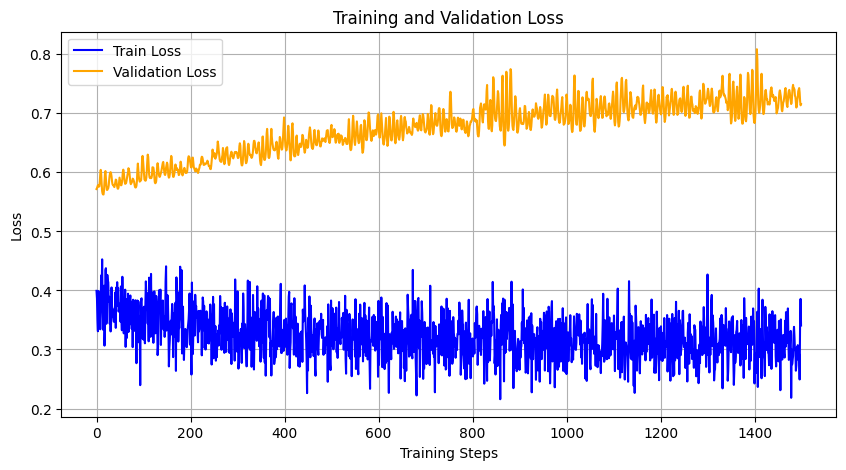

In [41]:
# plot the train losses and test losses.
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(agg_train_loss, label='Train Loss', color='blue')
plt.plot(agg_val_loss, label='Validation Loss', color='orange')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

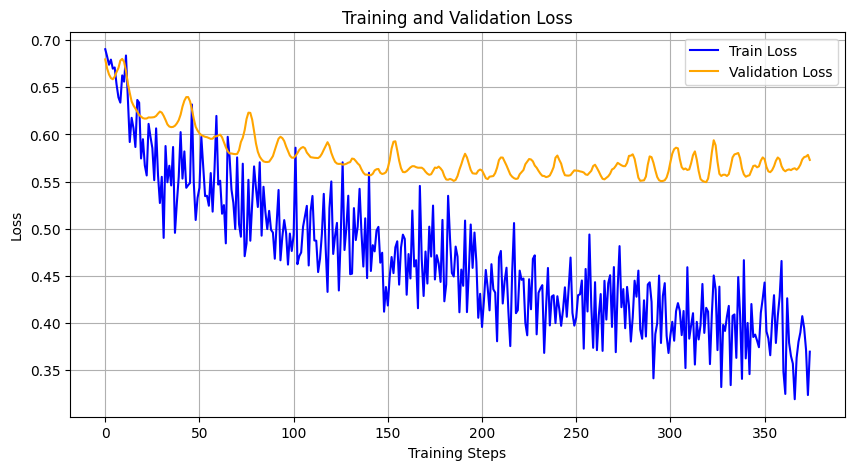

In [39]:
# plot the train losses and test losses.
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(agg_train_loss, label='Train Loss', color='blue')
plt.plot(agg_val_loss, label='Validation Loss', color='orange')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

#### LLM Router Training Instructions

In [51]:
# ----- 4. MLP Model -----
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 200),  # First layer with 200 hidden units
            nn.GELU(),                 # GELU activation
            nn.Linear(200, 200),       # Second layer with 200 hidden units
            nn.GELU(),                 # GELU activation
            nn.Linear(200, 1),         # Output layer
            nn.Sigmoid()               # Sigmoid for binary cross-entropy with soft targets
        )

    def forward(self, x):
        return self.model(x)

model = MLP(input_dim=1541)

# ----- 5. Loss and Optimizer -----
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for soft binary targets
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
# ----- 6. Training Loop -----
num_epochs = 100  # Maximum of 10,000 epochs
batch_size = 128    # Batch size of 128
patience = 10      # Early stopping patience

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

agg_train_loss = []
agg_val_loss = []
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = []
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    # Validation
    model.eval()
    val_loss = []
    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_preds = model(val_X)
            val_loss.append(criterion(val_preds, val_y).item())
    mean_train_loss = np.mean(train_loss)
    mean_val_loss = np.mean(val_loss)

    agg_train_loss.append(mean_train_loss)
    agg_val_loss.append(mean_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {mean_train_loss:.4f}, Val Loss: {mean_val_loss:.4f}")

    # Early stopping
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch 1, Train Loss: 0.6551, Val Loss: 0.6355
Epoch 2, Train Loss: 0.5965, Val Loss: 0.6153
Epoch 3, Train Loss: 0.5634, Val Loss: 0.5998
Epoch 4, Train Loss: 0.5426, Val Loss: 0.5848
Epoch 5, Train Loss: 0.5256, Val Loss: 0.5804
Epoch 6, Train Loss: 0.5127, Val Loss: 0.5756
Epoch 7, Train Loss: 0.5005, Val Loss: 0.5680
Epoch 8, Train Loss: 0.4891, Val Loss: 0.5629
Epoch 9, Train Loss: 0.4797, Val Loss: 0.5665
Epoch 10, Train Loss: 0.4708, Val Loss: 0.5563
Epoch 11, Train Loss: 0.4608, Val Loss: 0.5542
Epoch 12, Train Loss: 0.4519, Val Loss: 0.5580
Epoch 13, Train Loss: 0.4448, Val Loss: 0.5505
Epoch 14, Train Loss: 0.4367, Val Loss: 0.5516
Epoch 15, Train Loss: 0.4294, Val Loss: 0.5506
Epoch 16, Train Loss: 0.4224, Val Loss: 0.5527
Epoch 17, Train Loss: 0.4153, Val Loss: 0.5540
Epoch 18, Train Loss: 0.4079, Val Loss: 0.5584
Epoch 19, Train Loss: 0.4023, Val Loss: 0.5508
Epoch 20, Train Loss: 0.3953, Val Loss: 0.5562
Epoch 21, Train Loss: 0.3899, Val Loss: 0.5519
Epoch 22, Train Loss: 

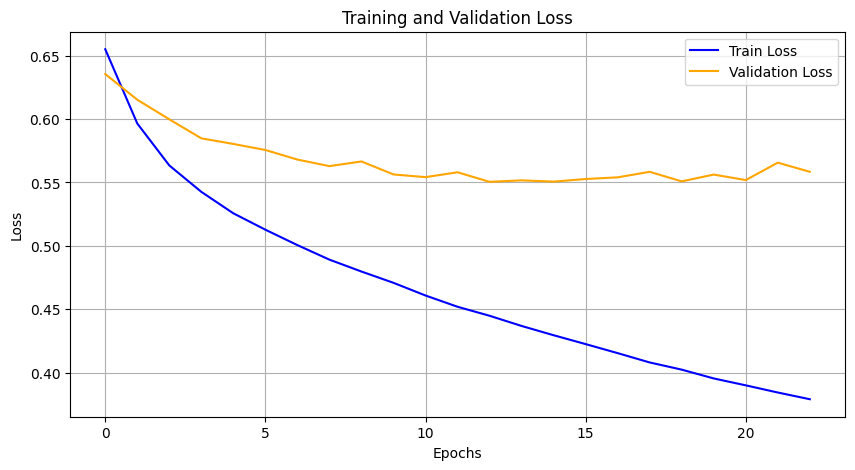

In [53]:
# ----- 7. Plot Training and Validation Loss -----
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(agg_train_loss, label='Train Loss', color='blue')
plt.plot(agg_val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Make Predictions on Test (soft label response).

In [54]:
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

with torch.no_grad():
    softLabel_Preds = model(X_test_tensor)

In [55]:
softLabel_preds_numpy = softLabel_Preds.squeeze().cpu().numpy()
softLabel_preds_numpy

array([0.683505  , 0.12039921, 0.2310139 , ..., 0.8031741 , 0.6483913 ,
       0.65304005], dtype=float32)

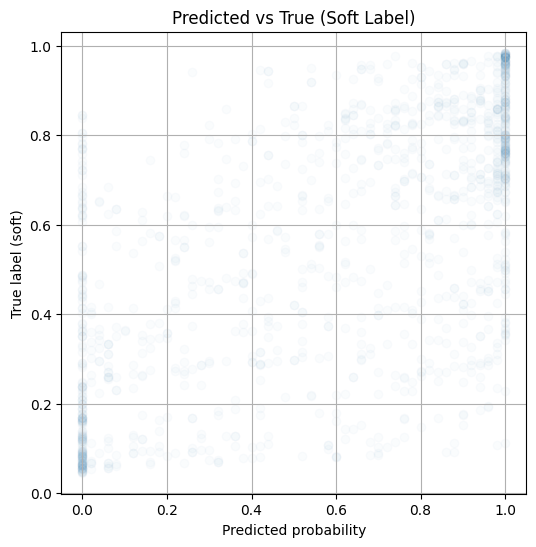

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, softLabel_preds_numpy, alpha=0.02)
plt.xlabel("Predicted probability")
plt.ylabel("True label (soft)")
plt.title("Predicted vs True (Soft Label)")
plt.grid(True)
plt.show()

### Add soft label predictions to test set

In [62]:
# dataframe with latencies and soft labels.
df_test.shape

(1200, 19)

In [64]:
df_test['predicted_prob'] = softLabel_preds_numpy
# df_train['predicted_prob'] = y_pred # softLabel_preds_numpy

In [65]:
# Dynamically extract the correctness_N column for each row
df_test["correctness"] = df_test.apply(lambda row: row[f"correctness_{row['N']}"], axis=1)

In [66]:
# there should be 18 different BoN configurations for each query in the test set.
df_train.groupby('sb_idx').size().reset_index(name='count')

,sb_idx,count
0,0,12
1,1,12
2,3,12
3,4,12
4,5,12
...,...,...
395,493,12
396,494,12
397,496,12
398,497,12


In [67]:
# Transform method columns into a single 'method' column.
def decode_method(row):
    if row["method_maj"]:
        return "majority"
    elif row["method_naive"]:
        return "naive"
    elif row["method_weighted"]:
        return "weighted"
    else:
        return "unknown"

# Apply the function row-wise
df_test["method"] = df_test.apply(decode_method, axis=1)
# df_train["method"] = df_train.apply(decode_method, axis=1)

# drop the one-hot columns
df_test = df_test.drop(columns=["method_maj", "method_naive", "method_weighted"])
# df_train = df_train.drop(columns=["method_maj", "method_naive", "method_weighted"])

In [68]:
df_test.head()
df_test.shape

(1200, 18)

In [69]:
# turn completion_tokens into a list of ints.
df_test["completion_tokens"] = df_test["completion_tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# df_train["completion_tokens"] = df_train["completion_tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [70]:
# compute token counts.
df_test["token_count"] = df_test.apply(lambda row: sum(row["completion_tokens"][:row["N"]]), axis=1)
# df_train["token_count"] = df_train.apply(lambda row: sum(row["completion_tokens"][:row["N"]]), axis=1)

In [71]:
df_test.head(5)

,question,score,score_list,completion_tokens,sb_idx,correctness_1,correctness_2,correctness_4,correctness_8,correctness_16,sl,N,question_length,token_count,method,time,predicted_prob,correctness
0,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[475, 561, 426, 431, 446, 515, 491, 431, 489, ...",2,[True],"[True, True]","[True, True, True, True]","[True, True, True, True, True, True, True, True]","[True, True, True, True, True, True, True, Tru...",0.92,2,113,1036,weighted,2.20,0.683505,"[True, True]"
1,What is the least positive integer multiple of...,"[0.0084228516, 0.0031738281, 0.0012817383, 0.7...","[0.0084228516, 0.0031738281, 0.0012817383, 0.7...","[273, 416, 447, 300, 447, 561, 310, 561, 349, ...",10,[False],"[False, False]","[False, False, False, False]","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",0.14,2,99,689,weighted,3.23,0.120399,"[False, False]"
2,"The proper divisors of 12 are 1, 2, 3, 4 and 6...","[0.0615234375, 0.9921875, 0.96875, 0.72265625,...","[0.0615234375, 0.9921875, 0.96875, 0.72265625,...","[461, 274, 585, 577, 433, 385, 429, 541, 270, ...",12,[False],"[False, False]","[False, False, False, False]","[False, False, False, False, False, False, Tru...","[False, False, False, False, False, False, Tru...",0.08,2,215,735,weighted,2.12,0.231014,"[False, False]"
3,The volume of the cylinder shown is $45\pi$ cu...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[230, 156, 169, 205, 207, 204, 163, 226, 234, ...",13,[True],"[True, True]","[True, True, True, True]","[True, True, True, True, True, True, True, True]","[True, True, True, True, True, True, True, Tru...",1.00,2,384,386,weighted,1.08,0.762827,"[True, True]"
4,Compute: $1-2+3-4+5- \dots +99-100$.,"[0.578125, 1.0, 1.0, 0.0344238281, 0.15625, 1....","[0.578125, 1.0, 1.0, 0.0344238281, 0.15625, 1....","[494, 374, 179, 712, 246, 232, 346, 327, 166, ...",16,[False],"[False, True]","[False, True, True, False]","[False, True, True, False, False, True, False,...","[False, True, True, False, False, True, False,...",0.84,2,36,868,weighted,1.60,0.609817,"[False, True]"


In [85]:
config_summary_df_test = df_test.groupby(["N", "method"])[
    ["sl", "token_count", "time"]
].mean().reset_index()

What I was doing before was comparing the adaptive router against the static config training data, rather than against the test data.

In [86]:
config_summary_df_test.head(20)

,N,method,sl,token_count,time
0,2,majority,0.4220,1000.61,2.9484
1,2,naive,0.5278,1000.61,3.0595
2,2,weighted,0.5278,1000.61,3.0595
3,4,majority,0.5138,1967.26,3.0719
4,4,naive,0.6062,1967.26,3.2847
5,4,weighted,0.6052,1967.26,3.2847
6,8,majority,0.6000,3952.01,3.8376
7,8,naive,0.6544,3952.01,4.3191
8,8,weighted,0.6644,3952.01,4.3191
9,16,majority,0.6472,7925.87,4.6970


### Plot of Accuracies per Configuration
Config Summary DF.

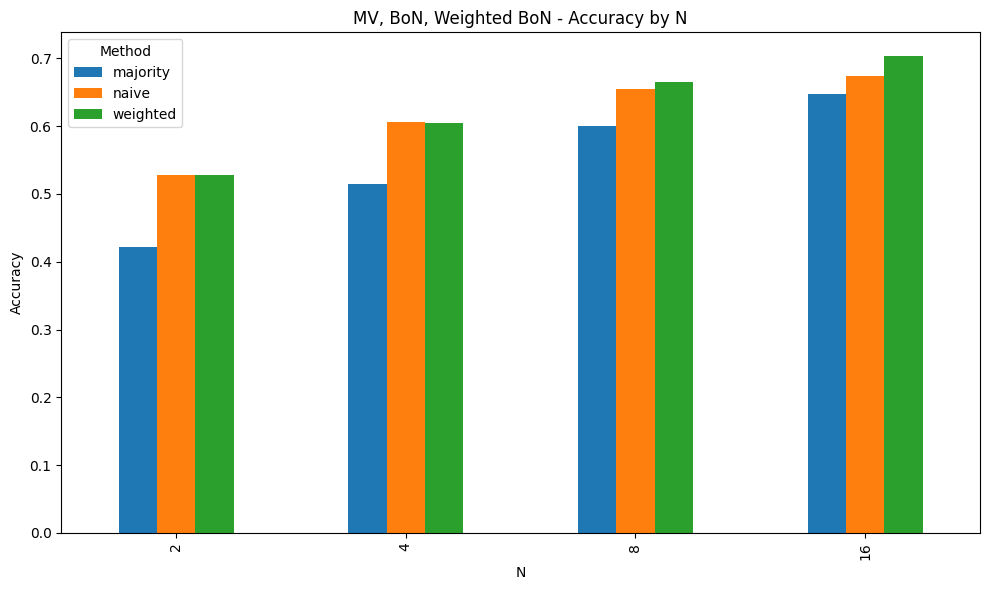

In [87]:
### TESTING DF
# Pivot for plotting
pivot_df = config_summary_df_test.pivot(index="N", columns="method", values="sl")

# Plot
pivot_df.plot(kind="bar", figsize=(10, 6))

plt.title("MV, BoN, Weighted BoN - Accuracy by N")
plt.xlabel("N")
plt.ylabel("Accuracy")
plt.legend(title="Method")
plt.tight_layout()
plt.show()

### Optimal-Utility Router

$$\text{Utility}(x, m) = \hat{a}_m(x) - \lambda \cdot \text{Cost}_m(x)$$

$$\text{Query-adaptive}(x, m) = \argmax_m \; \text{Utility}(x, m)

Input: A dataframe that contains rows for different settings (beam size, beam width, chunk size, etc.) and includes: an accuracy column, an avg_cot_token_count column (which is the cost), and a sb_idx column (which is the query).

A parameter, lambda, that controls how much the user is willing to tradeoff accuracy and cost.

For each group (i.e., all rows of the same query, or sb_idx):

It computes a utility value for each row:

$$\text{Utility}(x, m) = \hat{a}_m(x) - \lambda \cdot \text{Cost}_m(x)$$

It finds the row with the highest utility in that group.

Output:
A new DataFrame where each row corresponds to a query and contains:
the best utility found, the accuracy, and cost for that best-performing configuration.

In [147]:
def compute_max_utility_pred(df, lambda_1, lambda_2):
    def get_max_utility(group): # verified correctness. (July 22nd)
        group = group.copy()
        # group["utility"] = group["predicted_prob"] - lambda_1 * group["token_count"] - lambda_2 * group["time"]
        group["utility"] = group["sl"] - lambda_1 * group["token_count"] - lambda_2 * group["time"]
        idx_max = group["utility"].idxmax()
        # print("max utility index is: ", idx_max)
        return pd.Series({
            "max_utility": group.loc[idx_max, "utility"],
            "max_predicted_prob": group.loc[idx_max, "predicted_prob"],
            # "indicator": group.loc[idx_max, "indicator"], # indicator that keeps track of whether the answer is correct.
            "sl": group.loc[idx_max, "sl"],
            "max_cost": group.loc[idx_max, "token_count"],
            "max_time": group.loc[idx_max, "time"],
            "N": group.loc[idx_max, "N"],
            "method": group.loc[idx_max, "method"],
        })

    result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
    return result_df

#### Let's see what the router looks like for lambda = 0.

In [148]:
l1 = 0
l2 = 0
# for large lambda values, the max-accuracy is 0/1 because N is small in BoN.
adaptive_router_0_lambda = compute_max_utility_pred(df_test, l1, l2)
adaptive_router_0_lambda.head(20) # 100 questions in the test set.

/tmp/ipykernel_3598679/3373056775.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()


,sb_idx,max_utility,max_predicted_prob,sl,max_cost,max_time,N,method
0,2,1.00,0.774776,1.00,6920,3.66,16,weighted
1,10,0.64,0.142983,0.64,3315,11.64,8,weighted
2,12,0.28,0.241890,0.28,1897,3.46,4,naive
3,13,1.00,0.762827,1.00,386,1.08,2,weighted
4,16,1.00,0.652149,1.00,2910,3.31,8,weighted
5,28,0.94,0.905920,0.94,5767,2.48,16,weighted
6,30,1.00,0.747334,1.00,2650,1.75,8,weighted
7,32,0.98,0.336823,0.98,5602,5.47,16,weighted
8,44,0.96,0.815737,0.96,6685,4.13,16,weighted
9,53,0.96,0.903673,0.96,4325,2.33,16,weighted


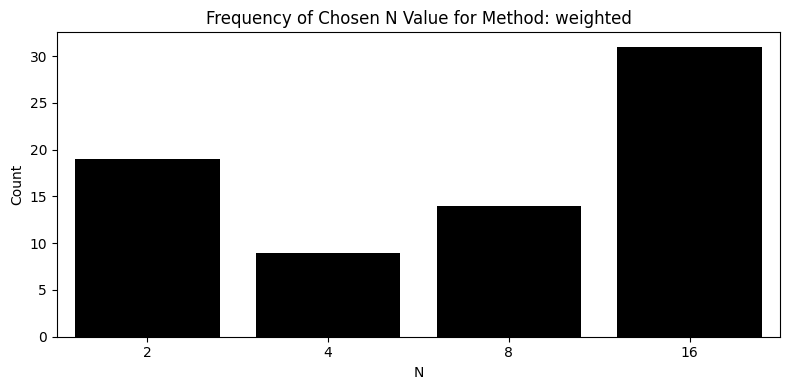

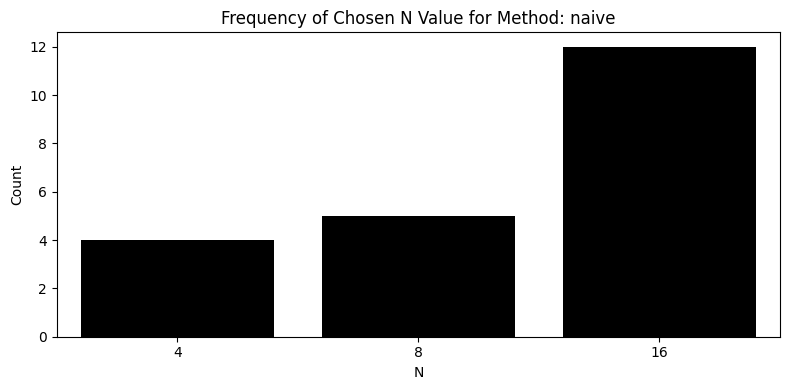

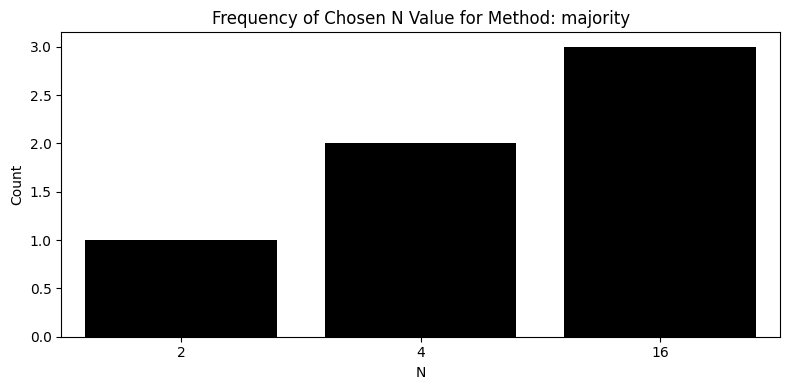

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

# # Plot: Histogram of method counts
# plt.figure(figsize=(8, 4))
# sns.countplot(data=adaptive_router_0_lambda, x="method", order=adaptive_router_0_lambda["method"].value_counts().index, color="black")
# plt.title("Frequency of Chosen Method")
# plt.xlabel("Method")
# plt.ylabel("Count")
# plt.tight_layout()
# plt.show()

# # Plot: Histogram of N values
# plt.figure(figsize=(8, 4))
# sns.countplot(data=adaptive_router_0_lambda, x="N", order=sorted(adaptive_router_0_lambda["N"].unique()), color="black")
# plt.title("Frequency of Chosen N Value")
# plt.xlabel("N")
# plt.ylabel("Count")
# plt.tight_layout()
# plt.show()

# filter by method and plot N.
methods = adaptive_router_0_lambda["method"].unique()
for method in methods:
    method_df = adaptive_router_0_lambda[adaptive_router_0_lambda["method"] == method]
    plt.figure(figsize=(8, 4))
    sns.countplot(data=method_df, x="N", order=sorted(method_df["N"].unique()), color="black")
    plt.title(f"Frequency of Chosen N Value for Method: {method}")
    plt.xlabel("N")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

In [150]:
# average of indicator column to get the percentage of questions the router answers correctly.
average_accuracy = adaptive_router_0_lambda["sl"].mean()
average_cost = adaptive_router_0_lambda["max_cost"].mean()
print(f"Average accuracy for lambda={0} is {average_accuracy:.4f}, average cost is: {average_cost:.4f}")
# print(f"Average cost is: {average_cost:.4f}")

Average accuracy for lambda=0 is 0.7368, average cost is: 4793.6300


In [126]:
# Sweep over lambda values 
lambda_1_list = [0] * 100 # np.logspace(-50, -1, num=25) 
lambda_2_list = np.logspace(-50, -1, num=100) 

In [151]:
results = []

for lambda_value in lambda_2_list:
    adaptive_router = compute_max_utility_pred(df_test, lambda_value, 0)
    average_accuracy = adaptive_router["sl"].mean() # accuracy as a percentage of questions (out of all questions in the test set) answered correctly.
    average_cost = adaptive_router["max_cost"].mean()
    average_predicted_prob = adaptive_router["max_predicted_prob"].mean()
    average_time = adaptive_router["max_time"].mean()
    
    results.append({
        "lambda": lambda_value,
        "sl": average_accuracy,
        "token_count": average_cost,
        "predicted_prob": average_predicted_prob,
        "time": average_time,
    })

# Convert to DataFrame
# query_adaptive_df = pd.DataFrame(results)
# query_adaptive_df.head()
query_adaptive_df_oracle = pd.DataFrame(results)
query_adaptive_df_oracle.head()

/tmp/ipykernel_3598679/3373056775.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_3598679/3373056775.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_3598679/3373056775.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping co

,lambda,sl,token_count,predicted_prob,time
0,1.000000e-50,0.7368,4793.63,0.571479,4.8359
1,3.125716e-50,0.7368,4793.63,0.571479,4.8359
2,9.770100e-50,0.7368,4793.63,0.571479,4.8359
3,3.053856e-49,0.7368,4793.63,0.571479,4.8359
4,9.545485e-49,0.7368,4793.63,0.571479,4.8359


In [152]:
# the routed queries.
query_adaptive_df_oracle.head()
query_adaptive_df_oracle["method"] = "oracle"

In [153]:
query_adaptive_df.head()
query_adaptive_df["method"] = "adaptive"

In [154]:
query_adaptive_df_oracle

,lambda,sl,token_count,predicted_prob,time,method
0,1.000000e-50,0.7368,4793.63,0.571479,4.8359,oracle
1,3.125716e-50,0.7368,4793.63,0.571479,4.8359,oracle
2,9.770100e-50,0.7368,4793.63,0.571479,4.8359,oracle
3,3.053856e-49,0.7368,4793.63,0.571479,4.8359,oracle
4,9.545485e-49,0.7368,4793.63,0.571479,4.8359,oracle
...,...,...,...,...,...,...
95,1.047616e-03,0.5308,1001.86,0.526856,3.0598,oracle
96,3.274549e-03,0.5282,1000.61,0.526710,3.0572,oracle
97,1.023531e-02,0.5282,1000.61,0.526710,3.0572,oracle
98,3.199267e-02,0.5282,1000.61,0.526710,3.0572,oracle


In [134]:
config_summary_df_test

,N,method,sl,token_count,time
0,2,majority,0.4220,1000.61,2.9484
1,2,naive,0.5278,1000.61,3.0595
2,2,weighted,0.5278,1000.61,3.0595
3,4,majority,0.5138,1967.26,3.0719
4,4,naive,0.6062,1967.26,3.2847
5,4,weighted,0.6052,1967.26,3.2847
6,8,majority,0.6000,3952.01,3.8376
7,8,naive,0.6544,3952.01,4.3191
8,8,weighted,0.6644,3952.01,4.3191
9,16,majority,0.6472,7925.87,4.6970


In [158]:
# outer join on the shared columns ("accuracy", "avg_cot_token_count")
query_optimal_static_df = pd.merge(
    query_adaptive_df,
    # config_summary_df,
    config_summary_df_test,
    on=["method", "sl", "token_count", "time"],
    how="outer"
)
query_optimal_static_df.head()
# change NaN to -1 for plotting purposes.
query_optimal_static_df = query_optimal_static_df.fillna(-1)

In [159]:
query_optimal_static_df

,lambda,sl,token_count,predicted_prob,time,method,N
0,0.000335,0.5278,1000.61,0.527335,3.0595,adaptive,-1.0
1,0.001048,0.5278,1000.61,0.527335,3.0595,adaptive,-1.0
2,0.003275,0.5278,1000.61,0.527335,3.0595,adaptive,-1.0
3,0.010235,0.5278,1000.61,0.527335,3.0595,adaptive,-1.0
4,0.031993,0.5278,1000.61,0.527335,3.0595,adaptive,-1.0
...,...,...,...,...,...,...,...
107,-1.000000,0.6744,7925.87,-1.000000,5.7883,naive,16.0
108,-1.000000,0.5278,1000.61,-1.000000,3.0595,weighted,2.0
109,-1.000000,0.6052,1967.26,-1.000000,3.2847,weighted,4.0
110,-1.000000,0.6644,3952.01,-1.000000,4.3191,weighted,8.0


In [160]:
query_adaptive_df_oracle

,lambda,sl,token_count,predicted_prob,time,method
0,1.000000e-50,0.7368,4793.63,0.571479,4.8359,oracle
1,3.125716e-50,0.7368,4793.63,0.571479,4.8359,oracle
2,9.770100e-50,0.7368,4793.63,0.571479,4.8359,oracle
3,3.053856e-49,0.7368,4793.63,0.571479,4.8359,oracle
4,9.545485e-49,0.7368,4793.63,0.571479,4.8359,oracle
...,...,...,...,...,...,...
95,1.047616e-03,0.5308,1001.86,0.526856,3.0598,oracle
96,3.274549e-03,0.5282,1000.61,0.526710,3.0572,oracle
97,1.023531e-02,0.5282,1000.61,0.526710,3.0572,oracle
98,3.199267e-02,0.5282,1000.61,0.526710,3.0572,oracle


In [161]:
query_optimal_static_df = pd.merge(
    query_optimal_static_df,
    query_adaptive_df_oracle,
    on=["lambda", "sl", "token_count", "predicted_prob", "time", "method"],
    how="outer"
)

In [162]:
query_optimal_static_df

,lambda,sl,token_count,predicted_prob,time,method,N
0,-1.000000,0.4220,1000.61,-1.000000,2.9484,majority,2.0
1,-1.000000,0.5138,1967.26,-1.000000,3.0719,majority,4.0
2,-1.000000,0.5278,1000.61,-1.000000,3.0595,naive,2.0
3,-1.000000,0.5278,1000.61,-1.000000,3.0595,weighted,2.0
4,-1.000000,0.6000,3952.01,-1.000000,3.8376,majority,8.0
...,...,...,...,...,...,...,...
207,0.010235,0.5282,1000.61,0.526710,3.0572,oracle,NaN
208,0.031993,0.5278,1000.61,0.527335,3.0595,adaptive,-1.0
209,0.031993,0.5282,1000.61,0.526710,3.0572,oracle,NaN
210,0.100000,0.5278,1000.61,0.527335,3.0595,adaptive,-1.0


In [164]:
# Replace NaN values with -1 for plotting purposes
query_optimal_static_df = query_optimal_static_df.fillna(-1)

# Display the merged DataFrame
query_optimal_static_df.head(20)

,lambda,sl,token_count,predicted_prob,time,method,N
0,-1.000000e+00,0.4220,1000.61,-1.000000,2.9484,majority,2.0
1,-1.000000e+00,0.5138,1967.26,-1.000000,3.0719,majority,4.0
2,-1.000000e+00,0.5278,1000.61,-1.000000,3.0595,naive,2.0
3,-1.000000e+00,0.5278,1000.61,-1.000000,3.0595,weighted,2.0
4,-1.000000e+00,0.6000,3952.01,-1.000000,3.8376,majority,8.0
5,-1.000000e+00,0.6052,1967.26,-1.000000,3.2847,weighted,4.0
6,-1.000000e+00,0.6062,1967.26,-1.000000,3.2847,naive,4.0
7,-1.000000e+00,0.6472,7925.87,-1.000000,4.6970,majority,16.0
8,-1.000000e+00,0.6544,3952.01,-1.000000,4.3191,naive,8.0
9,-1.000000e+00,0.6644,3952.01,-1.000000,4.3191,weighted,8.0


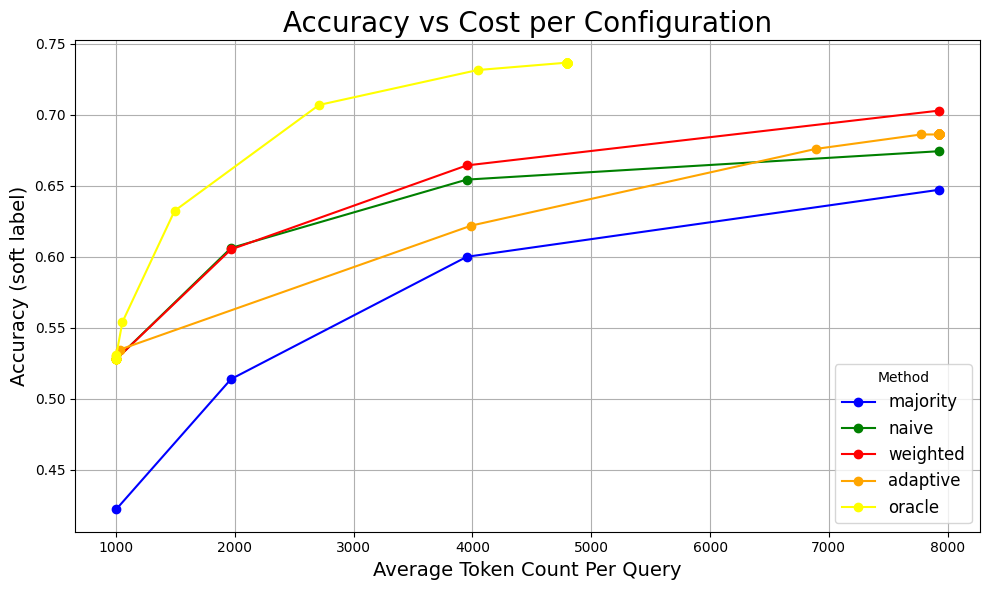

In [166]:
# Assign unique colors for each method
method_colors = {
    "majority": "blue",
    "naive": "green",
    "weighted": "red",
    "adaptive": "orange",  # Query-adaptive router
    "oracle": "yellow"  # Oracle router
}

# Replace -1 with "adaptive" in the DataFrame
# query_optimal_static_df["method"] = query_optimal_static_df["method"].replace(-1, "adaptive")

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate over each method and plot its points and connecting lines
for method in query_optimal_static_df["method"].unique():
    method_df = query_optimal_static_df[query_optimal_static_df["method"] == method]
    color = method_colors.get(method, "gray")  # Default to gray if method is unknown
    plt.plot(
        method_df["token_count"], 
        method_df["sl"], 
        marker="o", 
        linestyle="-", 
        color=color, 
        label=method
    )

# Add labels and title
plt.xlabel("Average Token Count Per Query", fontsize=14)
plt.ylabel("Accuracy (soft label)", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.legend(title="Method", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

['majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx2.0', 'qa', 'majorityx4.0', 'naivex2.0', 'weightedx2.0', 'qa', 'naivex4.0', 'weightedx4.0', 'majorityx8.0', 'naivex8.0', 'weightedx8.0', 'majorityx16.0', 'qa', 'naivex16.0', 'naivex32.0', 'majorityx32.0', 'weightedx16.0', 'weightedx32.0', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa']


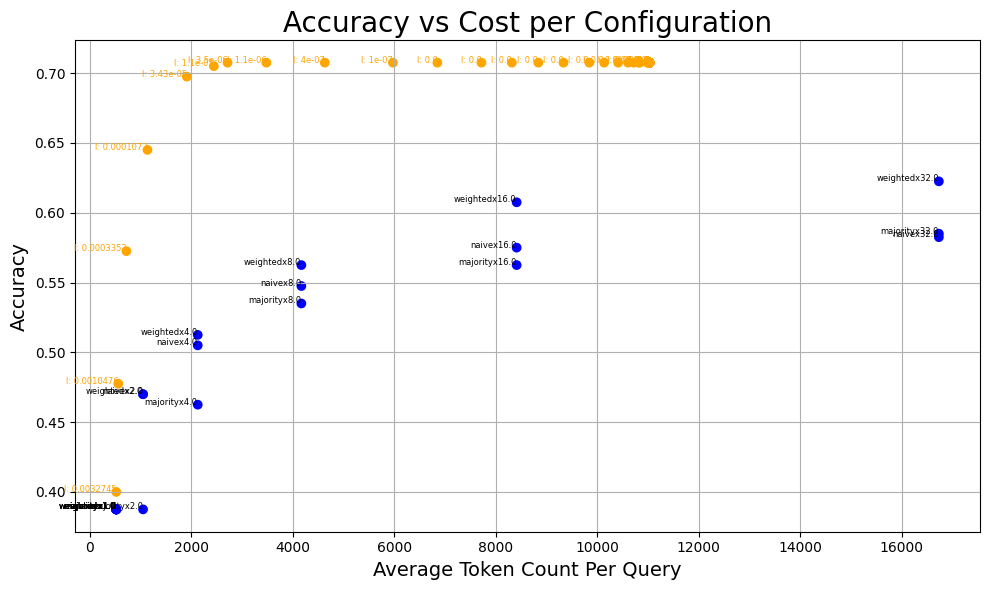

In [ ]:
# Create color labels and text labels
colors = ['orange' if (row['method']) == -1 else 'blue'
          for _, row in query_optimal_static_df.iterrows()]

text_labels = ["qa" if (row['method']) == -1
               else f"{row['method']}x{row['N']}"
               for _, row in query_optimal_static_df.iterrows()]

print(text_labels)
plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_static_df["token_count"], query_optimal_static_df["indicator"], color=colors)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='black')
    elif label == "qa":
        plt.annotate(f"l: {round(query_optimal_static_df["lambda"][i], 7)}",
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='orange')

plt.xlabel("Average Token Count Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.grid(True)
plt.tight_layout()

# plt.savefig("figs/accuracy_vs_cost_by_config3", dpi=300, bbox_inches='tight')

# notes: make sure we are plotting the accuracy. the probe should pick the weighted response.
# should not go below the blue dots. (check what you are actually plotting).